# 📊 ModSim - Análisis de Resultados (Experimentos)
**Propósito.** Analizar `exp_grid.csv` generado por `python -m src.cli.run_grid` y producir KPIs, tablas comparativas y gráficas finales para el informe.

**Incluye:**
1) Carga de datos, verificación y sanity checks.  
2) KPIs agregados por política, # pickers y congestión.  
3) Comparativas de **Throughput** y **Espera promedio** por política.  
4) Selección de **mejores configuraciones** por objetivo (max throughput / min espera / min util_max).  
5) Sensibilidades para **Batching_Size** (tamaño de batch) y **Batching_Time** (umbral).  
6) Export de gráficos a `outputs/plots_notebook/`.


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)


In [2]:
CSV_PATH = Path("outputs/experiments/exp_grid.csv")  # cambia si lo guardaste en otro lugar
PLOTS_DIR = Path("outputs/plots_notebook")
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

assert CSV_PATH.exists(), f"No se encontró el CSV en {CSV_PATH}. Corre: python -m src.cli.run_grid"


In [3]:
df = pd.read_csv(CSV_PATH)
print(df.shape)
df.head(10)


(120, 14)


,policy,n_pickers,speed_m_per_min,congestion,batch_size,time_threshold_min,sku_popularity,seed,orders_total,makespan_min,throughput_per_hour,avg_wait_min,util_avg,util_max
0,Secuencial_FCFS,1,60.0,off,0,0.0,uniforme,7,148,179.656718,49.427598,0.258588,0.422658,0.422658
1,Secuencial_FCFS,1,60.0,light,0,0.0,uniforme,7,148,179.656718,49.427598,0.258588,0.422658,0.422658
2,Secuencial_FCFS,2,60.0,off,0,0.0,uniforme,7,148,179.656718,49.427598,0.025190,0.211329,0.312633
3,Secuencial_FCFS,2,60.0,light,0,0.0,uniforme,7,148,179.656718,49.427598,0.035373,0.223018,0.321428
4,Secuencial_FCFS,3,60.0,off,0,0.0,uniforme,7,148,179.656718,49.427598,0.001940,0.140886,0.305768
5,Secuencial_FCFS,3,60.0,light,0,0.0,uniforme,7,148,179.656718,49.427598,0.003954,0.150682,0.311028
6,Batching_Size,1,60.0,off,5,0.0,uniforme,7,148,177.104388,50.139921,0.000000,0.169015,0.169015
7,Batching_Size,1,60.0,off,10,0.0,uniforme,7,148,172.468875,51.487551,0.000000,0.116156,0.116156
8,Batching_Size,1,60.0,light,5,0.0,uniforme,7,148,177.104388,50.139921,0.000000,0.169015,0.169015
9,Batching_Size,1,60.0,light,10,0.0,uniforme,7,148,172.468875,51.487551,0.000000,0.116156,0.116156


In [4]:
required = {"policy","n_pickers","speed_m_per_min","congestion","batch_size","time_threshold_min",
            "sku_popularity","seed","orders_total","makespan_min","throughput_per_hour",
            "avg_wait_min","util_avg","util_max"}
missing = required - set(df.columns)
assert not missing, f"Columnas faltantes: {missing}"

summary = df[["throughput_per_hour","avg_wait_min","util_avg","util_max","orders_total","makespan_min"]].describe()
summary


,throughput_per_hour,avg_wait_min,util_avg,util_max,orders_total,makespan_min
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,46.689631,0.008118,0.107283,0.166113,137.900000,177.277525
std,3.511062,0.037792,0.081819,0.081768,10.146324,3.820340
min,42.333333,0.000000,0.021431,0.064292,127.000000,167.983801
25%,42.747779,0.000000,0.051392,0.112203,128.000000,177.046055
50%,47.573146,0.000000,0.082751,0.142334,138.000000,179.390051
75%,49.501073,0.000000,0.133490,0.223773,148.000000,179.658458
max,51.687345,0.258588,0.422658,0.422658,148.000000,180.000000


In [5]:
thr_by_pol_pickers = (df
    .groupby(["policy","n_pickers"], as_index=False)["throughput_per_hour"]
    .mean()
    .sort_values(["policy","n_pickers"])
)
thr_by_pol_pickers


,policy,n_pickers,throughput_per_hour
0,Batching_Size,1,47.688395
1,Batching_Size,2,47.688395
2,Batching_Size,3,47.688395
3,Batching_Time,1,46.086266
4,Batching_Time,2,46.086266
5,Batching_Time,3,46.086266
6,Secuencial_FCFS,1,45.898834
7,Secuencial_FCFS,2,45.898834
8,Secuencial_FCFS,3,45.898834


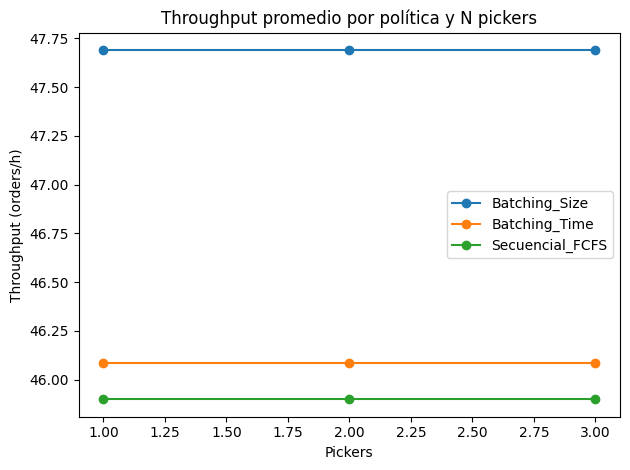

Guardado: outputs\plots_notebook\throughput_by_policy_and_pickers.png


In [6]:
plt.figure()
for pol in thr_by_pol_pickers["policy"].unique():
    sub = thr_by_pol_pickers[thr_by_pol_pickers["policy"]==pol]
    plt.plot(sub["n_pickers"], sub["throughput_per_hour"], marker="o", label=pol)
plt.xlabel("Pickers")
plt.ylabel("Throughput (orders/h)")
plt.title("Throughput promedio por política y N pickers")
plt.legend()
plt.tight_layout()
out1 = PLOTS_DIR / "throughput_by_policy_and_pickers.png"
plt.savefig(out1)
plt.show()
print(f"Guardado: {out1}")


C:\Users\garci\AppData\Local\Temp\ipykernel_13640\900623491.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=pols)


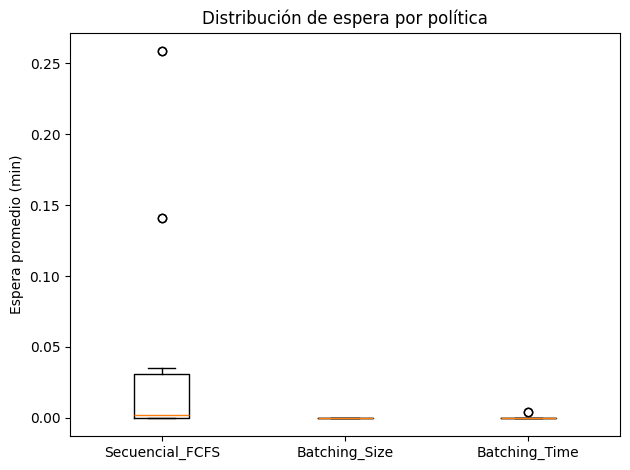

Guardado: outputs\plots_notebook\wait_box_by_policy.png


In [7]:
plt.figure()
pols = list(df["policy"].unique())
data = [df[df["policy"]==p]["avg_wait_min"].values for p in pols]
plt.boxplot(data, labels=pols)
plt.ylabel("Espera promedio (min)")
plt.title("Distribución de espera por política")
plt.tight_layout()
out2 = PLOTS_DIR / "wait_box_by_policy.png"
plt.savefig(out2)
plt.show()
print(f"Guardado: {out2}")


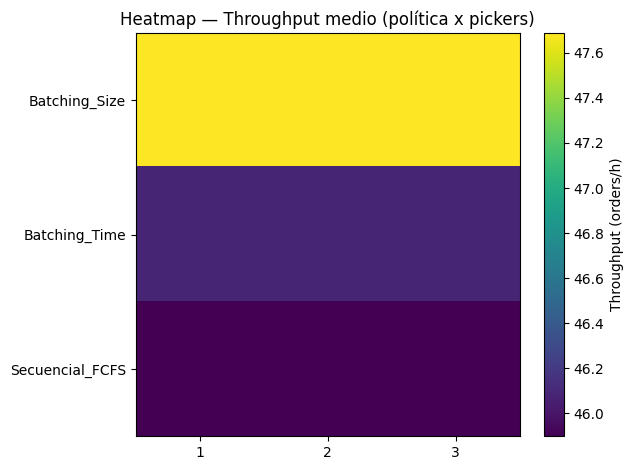

Guardado: outputs\plots_notebook\heatmap_throughput_policy_pickers.png


n_pickers,1,2,3
policy,,,
Batching_Size,47.688,47.688,47.688
Batching_Time,46.086,46.086,46.086
Secuencial_FCFS,45.899,45.899,45.899


In [8]:
pivot_thr = df.pivot_table(index="policy", columns="n_pickers", values="throughput_per_hour", aggfunc="mean")
plt.figure()
plt.imshow(pivot_thr.values, aspect="auto")
plt.xticks(range(pivot_thr.shape[1]), pivot_thr.columns)
plt.yticks(range(pivot_thr.shape[0]), pivot_thr.index)
plt.colorbar(label="Throughput (orders/h)")
plt.title("Heatmap — Throughput medio (política x pickers)")
plt.tight_layout()
out3 = PLOTS_DIR / "heatmap_throughput_policy_pickers.png"
plt.savefig(out3)
plt.show()
print(f"Guardado: {out3}")
pivot_thr.round(3)


In [9]:
# Mejor throughput global
row_thr = df.loc[df["throughput_per_hour"].idxmax()]
# Menor espera global
row_wait = df.sort_values("avg_wait_min", ascending=True).iloc[0]
# Menor pico de utilización
row_util = df.loc[df["util_max"].idxmin()]

best_table = pd.DataFrame([row_thr, row_wait, row_util])[[
    "policy","n_pickers","congestion","batch_size","time_threshold_min",
    "sku_popularity","seed","throughput_per_hour","avg_wait_min","util_avg","util_max"
]].reset_index(drop=True)
best_table


,policy,n_pickers,congestion,batch_size,time_threshold_min,sku_popularity,seed,throughput_per_hour,avg_wait_min,util_avg,util_max
0,Batching_Size,1,off,10,0.0,concentrada,7,51.687345,0.0,0.070430,0.070430
1,Batching_Size,1,off,5,0.0,uniforme,7,50.139921,0.0,0.169015,0.169015
2,Batching_Size,1,off,10,0.0,concentrada,11,45.718694,0.0,0.064292,0.064292


In [10]:
bs = df[df["policy"]=="Batching_Size"]
agg_bsz = (bs.groupby(["batch_size","n_pickers"], as_index=False)
             [["throughput_per_hour","avg_wait_min","util_max"]]
             .mean())
agg_bsz.sort_values(["n_pickers","batch_size"])


,batch_size,n_pickers,throughput_per_hour,avg_wait_min,util_max
0,5,1,46.753127,0.0,0.125849
3,10,1,48.623663,0.0,0.088647
1,5,2,46.753127,0.0,0.125849
4,10,2,48.623663,0.0,0.088647
2,5,3,46.753127,0.0,0.125849
5,10,3,48.623663,0.0,0.088647


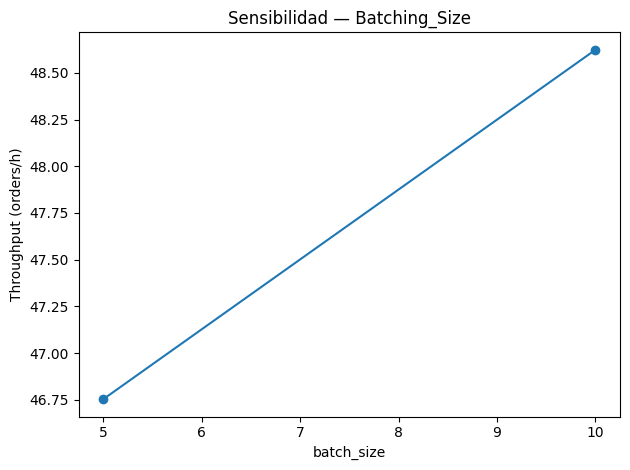

Guardado: outputs\plots_notebook\sensitivity_batch_size.png


In [11]:
plt.figure()
agg = bs.groupby("batch_size", as_index=False)["throughput_per_hour"].mean()
plt.plot(agg["batch_size"], agg["throughput_per_hour"], marker="o")
plt.xlabel("batch_size")
plt.ylabel("Throughput (orders/h)")
plt.title("Sensibilidad — Batching_Size")
plt.tight_layout()
out4 = PLOTS_DIR / "sensitivity_batch_size.png"
plt.savefig(out4)
plt.show()
print(f"Guardado: {out4}")


In [12]:
bt = df[df["policy"]=="Batching_Time"]
agg_thr_thr = (bt.groupby(["time_threshold_min","n_pickers"], as_index=False)
                 [["throughput_per_hour","avg_wait_min","util_max"]].mean())
agg_thr_thr.sort_values(["n_pickers","time_threshold_min"])


,time_threshold_min,n_pickers,throughput_per_hour,avg_wait_min,util_max
0,1.0,1,46.086266,0.000999,0.204535
3,2.0,1,46.086266,0.000000,0.170775
1,1.0,2,46.086266,0.000000,0.201891
4,2.0,2,46.086266,0.000000,0.170775
2,1.0,3,46.086266,0.000000,0.201891
5,2.0,3,46.086266,0.000000,0.170775


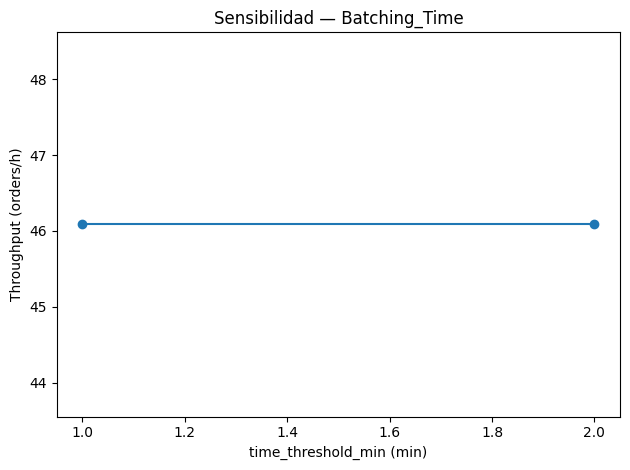

Guardado: outputs\plots_notebook\sensitivity_time_threshold.png


In [13]:
plt.figure()
agg = bt.groupby("time_threshold_min", as_index=False)["throughput_per_hour"].mean()
plt.plot(agg["time_threshold_min"], agg["throughput_per_hour"], marker="o")
plt.xlabel("time_threshold_min (min)")
plt.ylabel("Throughput (orders/h)")
plt.title("Sensibilidad — Batching_Time")
plt.tight_layout()
out5 = PLOTS_DIR / "sensitivity_time_threshold.png"
plt.savefig(out5)
plt.show()
print(f"Guardado: {out5}")


In [14]:
agg_cong = (df.groupby(["policy","congestion"], as_index=False)
              [["throughput_per_hour","avg_wait_min","util_avg"]].mean())
agg_cong.sort_values(["policy","congestion"])


,policy,congestion,throughput_per_hour,avg_wait_min,util_avg
0,Batching_Size,light,47.688395,0.000000,0.065540
1,Batching_Size,off,47.688395,0.000000,0.065540
2,Batching_Time,light,46.086266,0.000167,0.114733
3,Batching_Time,off,46.086266,0.000167,0.114678
4,Secuencial_FCFS,light,45.898834,0.040799,0.177745
5,Secuencial_FCFS,off,45.898834,0.039719,0.174102


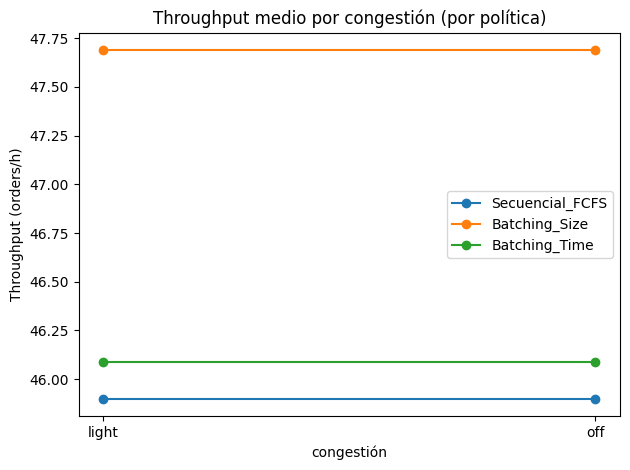

Guardado: outputs\plots_notebook\throughput_by_congestion.png


In [15]:
plt.figure()
for pol in df["policy"].unique():
    sub = df[df["policy"]==pol]
    a = sub.groupby("congestion")["throughput_per_hour"].mean()
    plt.plot(range(len(a.index)), a.values, marker="o", label=pol)
plt.xticks(range(len(a.index)), a.index)
plt.xlabel("congestión")
plt.ylabel("Throughput (orders/h)")
plt.title("Throughput medio por congestión (por política)")
plt.legend()
plt.tight_layout()
out6 = PLOTS_DIR / "throughput_by_congestion.png"
plt.savefig(out6)
plt.show()
print(f"Guardado: {out6}")


In [16]:
thr_by_pol_pickers.to_csv(PLOTS_DIR / "thr_by_pol_pickers.csv", index=False)
pivot_thr.to_csv(PLOTS_DIR / "pivot_throughput_policy_pickers.csv")
best_table.to_csv(PLOTS_DIR / "best_configs.csv", index=False)
print("Resúmenes exportados en:", PLOTS_DIR)


Resúmenes exportados en: outputs\plots_notebook
